## OOI Lab Manual 2025: Lab 6 Density Stratification

This notebook demonstrates how to access and process the dataset used in *Lab 6 Density Stratification* in the 2025 edition of the *OOI Lab Manual*.

By Sage Lichtenwalner, Rutgers University

Revised: January 16, 2025

In [1]:
# Notebook Setup
from erddapy import ERDDAP
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Setup a connection to the OOI ERDDAP server
server = "https://erddap.dataexplorer.oceanobservatories.org/erddap/"
e = ERDDAP(
    server=server,
    protocol="tabledap",
    response="csv",
)

### Activity 1 - Temperature, Salinity and Density Profile
For this first activity, we will pull a single profile (downcast) from the Endurance Array.

In [3]:
# Load the CTD data
url_ctd = e.get_download_url(
  dataset_id = 'ooi-ce09ospm-wfp01-03-ctdpfk000',
  variables = ['time','z','sea_water_temperature_profiler_depth_enabled','sea_water_pressure_profiler_depth_enabled',
               'sea_water_density_profiler_depth_enabled','sea_water_practical_salinity_profiler_depth_enabled'],
  constraints = { "time>=": "2024-04-19T11:55:00Z", "time<=": "2024-04-19T12:32:00Z",}
)
# print(url_ctd)
df_ctd = pd.read_csv(url_ctd, index_col='time', parse_dates=True, skiprows=[1])
df_ctd['z'] = df_ctd['z'] * -1
df_ctd.rename(columns={'z': 'depth', 
                       'sea_water_temperature_profiler_depth_enabled': 'temperature',
                       'sea_water_pressure_profiler_depth_enabled': 'pressure',
                       'sea_water_density_profiler_depth_enabled': 'density',
                       'sea_water_practical_salinity_profiler_depth_enabled': 'salinity' }, inplace=True)
df_ctd.head()

,depth,temperature,pressure,density,salinity
time,,,,,
2024-04-19 11:57:00+00:00,505.0,4.957071,510.206429,1029.387054,34.169517
2024-04-19 11:58:00+00:00,505.0,4.957143,510.208167,1029.387219,34.169728
2024-04-19 11:59:00+00:00,505.0,4.955159,510.142162,1029.387089,34.169631
2024-04-19 11:59:00+00:00,504.0,4.957680,508.884000,1029.381086,34.169764
2024-04-19 11:59:00+00:00,503.0,4.956850,507.852500,1029.376332,34.169624


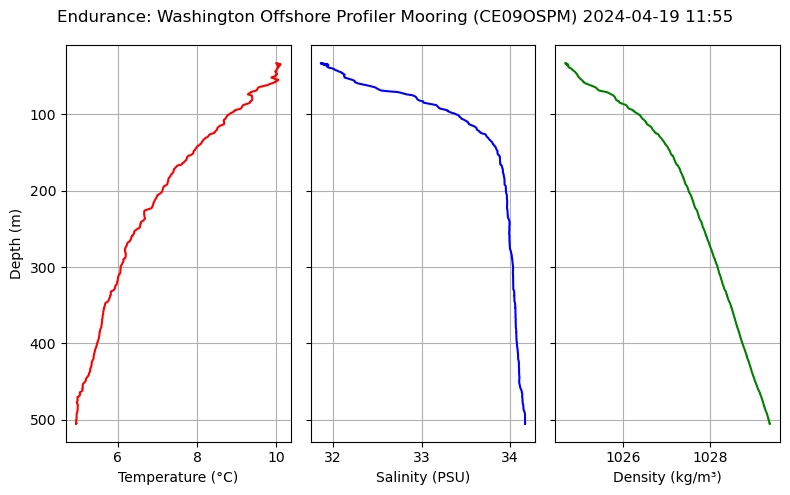

In [4]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(8,5))

# Plot Temperature Profile
ax1.plot(df_ctd['temperature'], df_ctd['depth'], color='red')
ax1.set_xlabel('Temperature (°C)')
ax1.set_ylabel('Depth (m)')
# ax1.set_title('Temperature')
ax1.grid(True)

# Plot Salinity Profile
ax2.plot(df_ctd['salinity'], df_ctd['depth'], color='blue')
ax2.set_xlabel('Salinity (PSU)')
# ax2.set_title('Salinity')
ax2.grid(True)

# Plot Density Profile
ax3.plot(df_ctd['density'], df_ctd['depth'], color='green')
ax3.set_xlabel('Density (kg/m³)')
# ax3.set_title('Density')
ax3.grid(True)
ax3.invert_yaxis()

fig.suptitle('Endurance: Washington Offshore Profiler Mooring (CE09OSPM) 2024-04-19 11:55')
plt.tight_layout()
plt.show()

In [5]:
# Save the data to a CSV file
df_ctd.to_csv('data/lab6_ce09ospm_ctd.csv', date_format='%Y-%m-%d %H:%M:%S', float_format='%.3f')

### Activity 3 - Profile Comparison

For this activity, we want temperature, salinity and density profile graphs from 
* Coastal Pioneer NES: Offshore Profiler Mooring: Wire-Following Profiler: CTD 
* Global Irminger Sea: Apex Profiler Mooring: Wire-Following Profiler Upper: CTD

We will create daily averages for each profiler from August 31, 2020 and  January 31, 2021 as representative seasonal profiles.

In [6]:
def get_profile(site, start_date, end_date):
  url_ctd = e.get_download_url(
    dataset_id = site, #'ooi-cp04ospm-wfp01-03-ctdpfk000',
    variables = ['time','z','sea_water_temperature_profiler_depth_enabled','sea_water_pressure_profiler_depth_enabled',
                'sea_water_density_profiler_depth_enabled','sea_water_practical_salinity_profiler_depth_enabled'],
    constraints = { "time>=": start_date, "time<=": end_date,}
  )
  # print(url_ctd)
  df_ctd = pd.read_csv(url_ctd, index_col='time', parse_dates=True, skiprows=[1])
  df_ctd['z'] = df_ctd['z'] * -1
  df_ctd.rename(columns={'z': 'depth', 
                        'sea_water_temperature_profiler_depth_enabled': 'temperature',
                        'sea_water_pressure_profiler_depth_enabled': 'pressure',
                        'sea_water_density_profiler_depth_enabled': 'density',
                        'sea_water_practical_salinity_profiler_depth_enabled': 'salinity' }, inplace=True)
    
  # Bin the data to depth bins with centers occurring on the 5's
  depth_bins = np.arange(2.5, df_ctd['depth'].max() + 5, 5)
  depth_labels = depth_bins[:-1] + 2.5
  df_ctd['depth_bin'] = pd.cut(df_ctd['depth'], bins=depth_bins, labels=depth_labels)

  # Group by the depth bins and calculate the mean for each bin
  df_ctd_resampled = df_ctd.groupby('depth_bin', observed=False).mean()
  return df_ctd_resampled



In [7]:
df_cp_aug = get_profile('ooi-cp04ospm-wfp01-03-ctdpfk000', '2020-08-31', '2020-09-01')
df_cp_jan = get_profile('ooi-cp04ospm-wfp01-03-ctdpfk000', '2021-01-31', '2021-02-01')
df_gi_aug = get_profile('ooi-gi02hypm-wfp02-04-ctdpfl000', '2020-08-31', '2020-09-01')
df_gi_jan = get_profile('ooi-gi02hypm-wfp02-04-ctdpfl000', '2021-01-31', '2021-02-01')

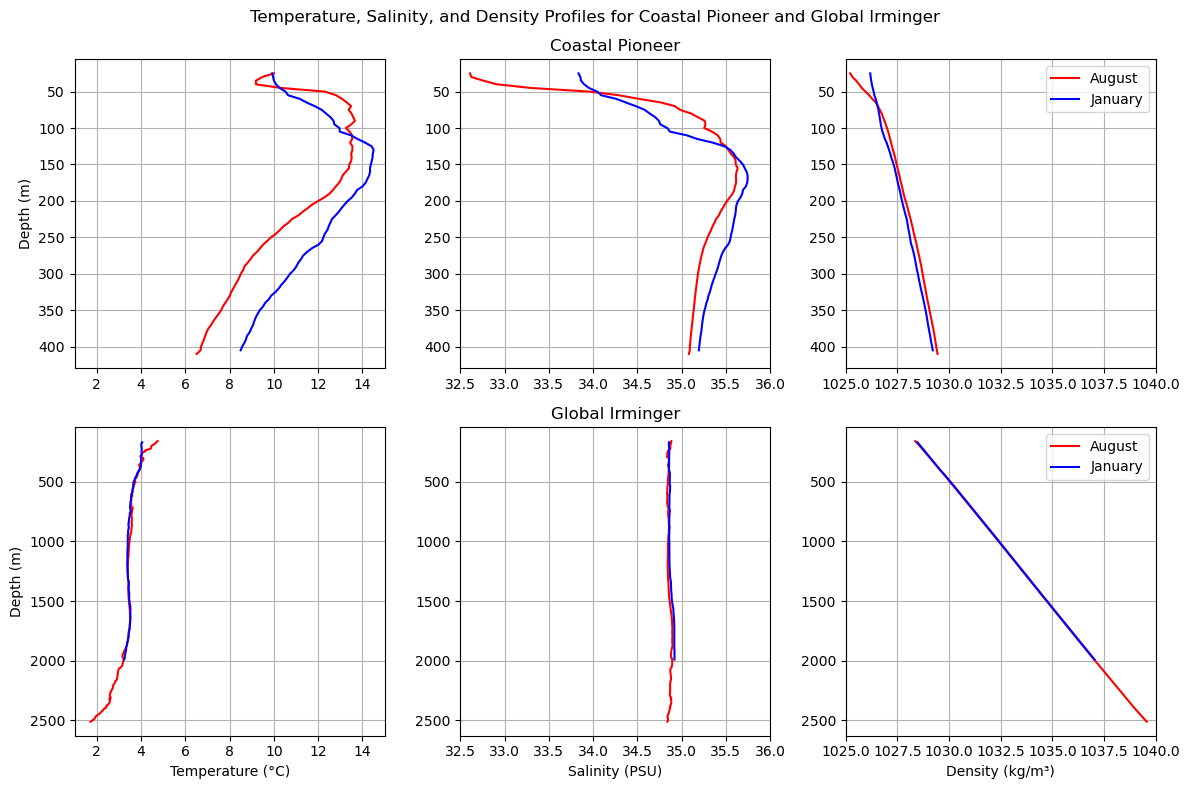

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Coastal Pioneer
axes[0, 0].plot(df_cp_aug['temperature'], df_cp_aug.index, color='red', label='August')
axes[0, 0].plot(df_cp_jan['temperature'], df_cp_jan.index, color='blue', label='January')
axes[0, 0].set_ylabel('Depth (m)')
axes[0, 0].set_xlim(1, 15)
axes[0, 0].grid(True)

axes[0, 1].plot(df_cp_aug['salinity'], df_cp_aug.index, color='red', label='August')
axes[0, 1].plot(df_cp_jan['salinity'], df_cp_jan.index, color='blue', label='January')
axes[0, 1].set_title('Coastal Pioneer')
axes[0, 1].set_xlim(32.5,36)
axes[0, 1].grid(True)

axes[0, 2].plot(df_cp_aug['density'], df_cp_aug.index, color='red', label='August')
axes[0, 2].plot(df_cp_jan['density'], df_cp_jan.index, color='blue', label='January')
axes[0, 2].grid(True)
axes[0, 2].set_xlim(1025, 1040)
axes[0, 2].legend()

# Global Irminger
axes[1, 0].plot(df_gi_aug['temperature'], df_gi_aug.index, color='red', label='August')
axes[1, 0].plot(df_gi_jan['temperature'], df_gi_jan.index, color='blue', label='January')
axes[1, 0].set_xlabel('Temperature (°C)')
axes[1, 0].set_ylabel('Depth (m)')
axes[1, 0].set_xlim(1, 15)
axes[1, 0].grid(True)

axes[1, 1].plot(df_gi_aug['salinity'], df_gi_aug.index, color='red', label='August')
axes[1, 1].plot(df_gi_jan['salinity'], df_gi_jan.index, color='blue', label='January')
axes[1, 1].set_xlabel('Salinity (PSU)')
axes[1, 1].set_title('Global Irminger')
axes[1, 1].set_xlim(32.5,36)
axes[1, 1].grid(True)

axes[1, 2].plot(df_gi_aug['density'], df_gi_aug.index, color='red', label='August')
axes[1, 2].plot(df_gi_jan['density'], df_gi_jan.index, color='blue', label='January')
axes[1, 2].set_xlabel('Density (kg/m³)')
axes[1, 2].set_xlim(1025, 1040)
axes[1, 2].grid(True)
axes[1, 2].legend()

# Invert y-axis for all plots
for ax in axes.flat:
    ax.invert_yaxis()

fig.suptitle('Temperature, Salinity, and Density Profiles for Coastal Pioneer and Global Irminger')
# plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.tight_layout()

plt.show()
fig.savefig('data/lab6_profiles.png', dpi=150)

In [10]:
# Add a column to specify the site/month
df_cp_aug['site'] = 'CP'
df_cp_jan['site'] = 'CP'
df_gi_aug['site'] = 'GI'
df_gi_jan['site'] = 'GI'

df_cp_aug['date'] = '2020-08-31'
df_cp_jan['date'] = '2021-01-31'
df_gi_aug['date'] = '2020-08-31'
df_gi_jan['date'] = '2021-01-31'

# Concatenate all four profile variables
df_all_profiles = pd.concat([df_cp_aug, df_cp_jan, df_gi_aug, df_gi_jan])

# Export to CSV
df_all_profiles.to_csv('data/lab6_profiles.csv', date_format='%Y-%m-%d %H:%M:%S', float_format='%.3f')